#EECS 442/504 PS9: Representation learning

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

Bernardo Bianco Prado, beprado

__Important__: after you download the .ipynb file, please name it as __"PS\<this_ps_number\>_\<your_uniqname\>.ipynb"__ before you submit it to canvas. Example: PS9_adam.ipynb.


# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the note book to your local machine as a .ipynb file for Canvas submission.

### Google Colab Setup
We need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

!pip install torchsummary
!pip install transformers
import pickle
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import time
import itertools

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary

import albumentations as A
import matplotlib.pyplot as plt
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from tqdm import tqdm_notebook
from tqdm.autonotebook import tqdm

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.2 MB/s 
     |████████████████████████████████| 182 kB 73.9 MB/s 
     |████████████████████████████████| 7.6 MB 43.7 MB/s 
PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113
Using the GPU!


# PS 9. Self-supervised learning

In this problem, we are going to implement two representation learning methods: an autoencoder and a recent constrastive learning method. 
We'll then test the features that were learned by these models on a "downstream" recognition task, using the STL-10 dataset.


# Downloading the dataset.

We use PyTorch built-in class to download  the STL-10 (http://ai.stanford.edu/~acoates/stl10/) dataset (a subset of ImageNet). The STL-10 dataset contains three partitions: train, test, and unlabeled. The train partition contains 10 image classes, each class with 500 images. The test partition contains 800 images for each class. The unlabeled contains a total of 100,000 images with many classes not in the train/test partitions.

In [ ]:
unlabeled_transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                         transforms.RandomCrop(64),
                                         transforms.ToTensor()])

labeled_transform = transforms.Compose([transforms.CenterCrop(64),
                                        transforms.ToTensor(),])


# We use the PyTorch built-in class to download the STL-10 dataset.
# The 'unlabeled' partition contains 100,000 images without labels.
# It's used for leanring representations with unsupervised learning. 
dataset_un = torchvision.datasets.STL10('./data', 'unlabeled', download=True, transform=unlabeled_transform)

dataset_tr = torchvision.datasets.STL10('./data', 'train', download=False, transform=labeled_transform)
dataset_te = torchvision.datasets.STL10('./data', 'test', download=False, transform=labeled_transform)

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data


In [ ]:
print('# of samples for ulabeled, train, and test, {}, {}, {}'.format(len(dataset_un), len(dataset_tr), len(dataset_te)))
print('Classes in train: {}'.format(dataset_tr.classes))

# of samples for ulabeled, train, and test, 100000, 5000, 8000
Classes in train: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


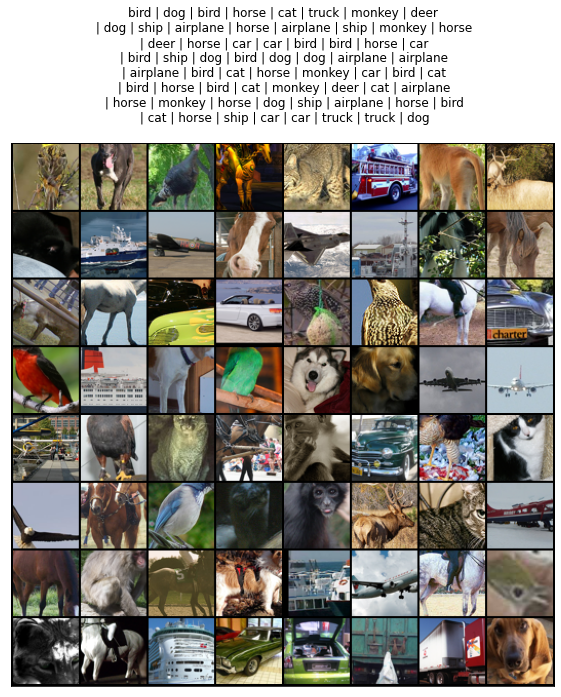

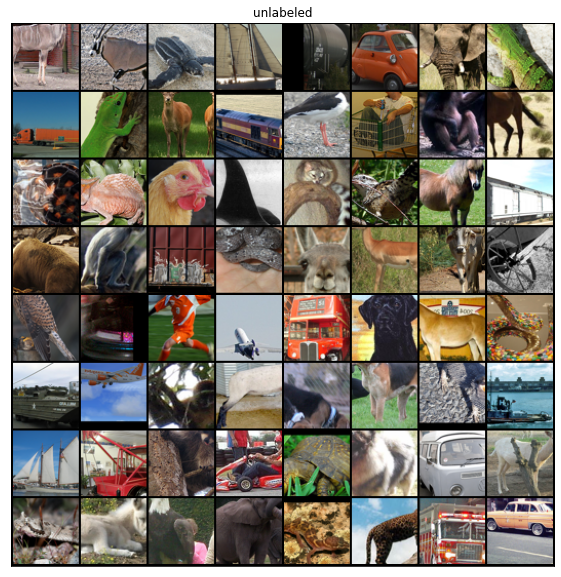

In [ ]:
# Visualize the data within the dataset
class_names = dict(zip(range(10), dataset_tr.classes))
dataloader_un = DataLoader(dataset_un, batch_size=64)
dataloader_tr = DataLoader(dataset_tr, batch_size=64)

def imshow(inp, title=None, ax=None, figsize=(5, 5)):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  if ax is None:
    fig, ax = plt.subplots(1, figsize=figsize)
  ax.imshow(inp)
  ax.set_xticks([])
  ax.set_yticks([])
  if title is not None:
    ax.set_title(title)

# Visualize training partition
# Get a batch of training data
inputs, classes = next(iter(dataloader_tr))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)

fig, ax = plt.subplots(1, figsize=(10, 10))
title = [class_names[x.item()] if (i+1) % 8 != 0 else class_names[x.item()]+'\n' for i, x in enumerate(classes)]
imshow(out, title=' | '.join(title), ax=ax)

# Visualize unlabeled partition
inputs, classes = next(iter(dataloader_un))
out = torchvision.utils.make_grid(inputs, nrow=8)

fig, ax = plt.subplots(1, figsize=(10, 10))
imshow(out, title='unlabeled', ax=ax)

As can be seen from above visualizations, the unlabeled partition contains classes that are not in the training partition. Though not labeled, the unlabeled partition has much more data than the labeled training partition. The large amount of unlabeled label ought to help us learn useful representations. In the next sections, we will use the unlabeled partition to help learn representations that is helpful for downstream tasks.

# Part 1. Autoencoders

We will first build an autoencoder. To keep training time low, we'll use a very simple network structure.

## 1.1 Build the encoder
Please make sure that your encoder has the same architeture as we print below before your proceed to the decoder part.

### Encoder archiecture

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #  
            Conv2d-1           [-1, 12, 32, 32]             588  
              ReLU-2           [-1, 12, 32, 32]               0  
            Conv2d-3           [-1, 24, 16, 16]           4,632  
              ReLU-4           [-1, 24, 16, 16]               0  
            Conv2d-5             [-1, 48, 8, 8]          18,480  
              ReLU-6             [-1, 48, 8, 8]               0   
            Conv2d-7             [-1, 24, 4, 4]          18,456  
              ReLU-8             [-1, 24, 4, 4]               0  
Total params: 42,156  
Trainable params: 42,156  
Non-trainable params: 0  
Input size (MB): 0.05
Forward/backward pass size (MB): 0.33  
Params size (MB): 0.16  
Estimated Total Size (MB): 0.54  

In [ ]:
class Encoder(nn.Module):
    def __init__(self, in_channels=3):
        super(Encoder, self).__init__()
        
        ##############################################################################
        #                               YOUR CODE HERE                               #
        ##############################################################################
        # TODO: Build an encoder with the architecture as specified above.           #
        ##############################################################################
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 12, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 48, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(48, 24, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################

    def forward(self, x):
        '''
        Given an image x, return the encoded latent representation h.

        Args:
            x: torch.tensor

        Return: 
            h: torch.tensor
        '''
        
        h = self.encoder(x)

        return h

In [ ]:
# Print out the neural network architectures and activation dimensions.
# Verify that your network has the same architecture as the one we printed above.
encoder = Encoder().to(device)
summary(encoder, [(3, 64, 64)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             588
              ReLU-2           [-1, 12, 32, 32]               0
            Conv2d-3           [-1, 24, 16, 16]           4,632
              ReLU-4           [-1, 24, 16, 16]               0
            Conv2d-5             [-1, 48, 8, 8]          18,480
              ReLU-6             [-1, 48, 8, 8]               0
            Conv2d-7             [-1, 24, 4, 4]          18,456
              ReLU-8             [-1, 24, 4, 4]               0
Total params: 42,156
Trainable params: 42,156
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.33
Params size (MB): 0.16
Estimated Total Size (MB): 0.54
----------------------------------------------------------------


## 1.2 Build the decoder

Next, we build the decoder to reconstruct the image from the latent representation extracted by the encoder. Please implement the decoder following the architectrue printed here. 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #  
              ConvTranspose2d-1   [-1, 48, 8, 8]         18,480  
              ReLU-2              [-1, 48, 8, 8]              0  
              ConvTranspose2d-3   [-1, 24, 16, 16]       18,456  
              ReLU-4              [-1, 24, 16, 16]            0
              ConvTranspose2d-5   [-1, 12, 32, 32]        4,620  
              ReLU-6              [-1, 12, 32, 32]            0  
              ConvTranspose2d-7   [-1, 3, 64, 64]           579  
              Sigmoid-8           [-1, 3, 64, 64]             0  

Total params: 42,135  
Trainable params: 42,135  
Non-trainable params: 0  
Input size (MB): 0.00  
Forward/backward pass size (MB): 0.52  
Params size (MB): 0.16  
Estimated Total Size (MB): 0.68  

In [ ]:
from torch.nn.modules.conv import ConvTranspose2d
class Decoder(nn.Module):
    def __init__(self, out_channels=3, feat_dim=64):
        super(Decoder, self).__init__()

        ##############################################################################
        #                               YOUR CODE HERE                               #
        ##############################################################################
        # TODO: Build the decoder as specified above.                                #
        ##############################################################################
        self.decoder = nn.Sequential(
            ConvTranspose2d(24, 48, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            ConvTranspose2d(48, 24, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            ConvTranspose2d(24, 12, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            ConvTranspose2d(12, out_channels, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################

    def forward(self, h):
        '''
        Given latent representation h, reconstruct an image patch of size 64 x 64.

        Args:
            h: torch.tensor

        Return: 
            x: torch.tensor
        '''
        x = self.decoder(h)
        return x

In [ ]:
# Print out the neural network architectures and activation dimensions.
# Verify that your network has the same architecture as the one we printed above.
decoder = Decoder().to(device)
summary(decoder, [(24, 4, 4)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 48, 8, 8]          18,480
              ReLU-2             [-1, 48, 8, 8]               0
   ConvTranspose2d-3           [-1, 24, 16, 16]          18,456
              ReLU-4           [-1, 24, 16, 16]               0
   ConvTranspose2d-5           [-1, 12, 32, 32]           4,620
              ReLU-6           [-1, 12, 32, 32]               0
   ConvTranspose2d-7            [-1, 3, 64, 64]             579
              ReLU-8            [-1, 3, 64, 64]               0
Total params: 42,135
Trainable params: 42,135
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 0.16
Estimated Total Size (MB): 0.68
----------------------------------------------------------------


## 1.3 Put together the autoencoder

Now we have the encoder and the decoder classes. We only need to implement another `Autoencoder` class to wrap the encoder and the decoder together.

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, in_channels=3, feat_dim=64):
        super(Autoencoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        '''
        Compress and reconstruct the input image with encoder and decoder.

        Args:
            x: torch.tensor

        Return: 
            x_: torch.tensor
        '''

        h = self.encoder(x)
        x_ = self.decoder(h)

        return x_

In [ ]:
# verify that your aueconder's output size is 3 x 64 x 64 
ae = Autoencoder().to(device)
summary(ae, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 32, 32]             588
              ReLU-2           [-1, 12, 32, 32]               0
            Conv2d-3           [-1, 24, 16, 16]           4,632
              ReLU-4           [-1, 24, 16, 16]               0
            Conv2d-5             [-1, 48, 8, 8]          18,480
              ReLU-6             [-1, 48, 8, 8]               0
            Conv2d-7             [-1, 24, 4, 4]          18,456
              ReLU-8             [-1, 24, 4, 4]               0
           Encoder-9             [-1, 24, 4, 4]               0
  ConvTranspose2d-10             [-1, 48, 8, 8]          18,480
             ReLU-11             [-1, 48, 8, 8]               0
  ConvTranspose2d-12           [-1, 24, 16, 16]          18,456
             ReLU-13           [-1, 24, 16, 16]               0
  ConvTranspose2d-14           [-1, 12,

## 1.4 Training the autoencoder

Now, we'll train the autoencoder to reconstruct images from the unlabeled set of STL-10. Note that the reconstructed images will contain significant artifacts, due to the limited size of the bottleneck between the encoder and decoder, and the small network size.

In [ ]:
# We train on 10,000 unsupervised samples instead of 100,000 samples to speed up training
n = 10000
dataset_un_subset, _ = torch.utils.data.random_split(dataset_un, [n,100000-n])
dataloader_un = DataLoader(dataset_un_subset, batch_size=128, shuffle=True)
dataloader_tr = DataLoader(dataset_tr, batch_size=128, shuffle=True)
dataloader_te = DataLoader(dataset_te, batch_size=128, shuffle=False)

In [ ]:
def visualize_recon(model, dataloader):
    '''
    Helper function for visualizing reconstruction performance.

    Randomly sample 8 images and plot the original/reconstructed images. 
    '''
    model.eval()
    img = next(iter(dataloader))[0][:8].to(device)
    out = model(img)

    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    inp = torchvision.utils.make_grid(torch.cat((img, out), dim=2), nrow=8)
    imshow(inp.detach().cpu(), ax=ax)
    model.train()
    plt.show()

In [ ]:
def train_ae(model, dataloader, epochs=200):
    '''
    Train autoencoder model.

    Args:
        model: torch.nn.module.
        dataloader: DataLoader. The unlabeled partition of the STL dataset.
    '''

    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    loss_traj = []

    for epoch in tqdm_notebook(range(epochs)):

        loss_epoch = 0
        for x, _ in dataloader:

            ##############################################################################
            #                               YOUR CODE HERE                               #
            ##############################################################################
            # TODO: Train the autoencoder on one minibatch.                              #
            ##############################################################################
            optimizer.zero_grad()
            x = x.to(device)
            out = model(x)
            loss = criterion(out, x)
            loss.backward()
            optimizer.step()


            ##############################################################################
            #                               END OF YOUR CODE                             #
            ##############################################################################
            loss_epoch += loss.detach()

        loss_traj.append(loss_epoch)
        
        if epoch % 10 == 0:
            print('Epoch {}, loss {:.3f}'.format(epoch, loss_epoch))
            visualize_recon(model, dataloader)

    return model, loss_traj

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, loss 6.376


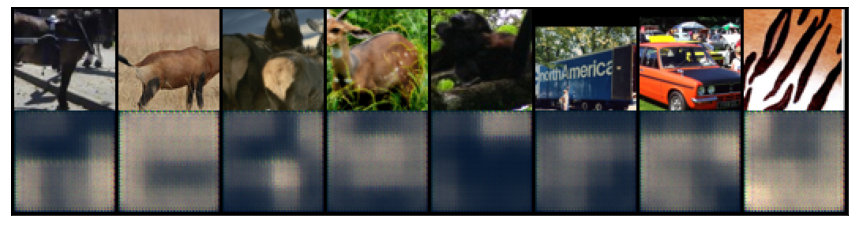

Epoch 10, loss 0.996


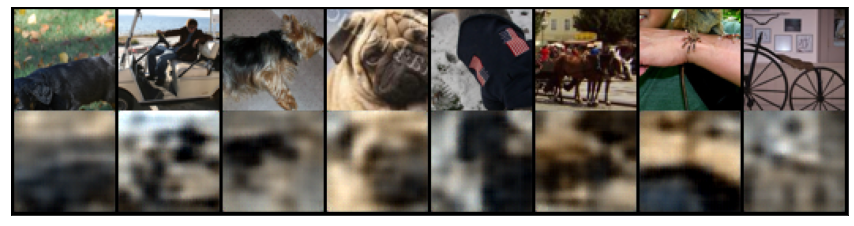

Epoch 20, loss 0.865


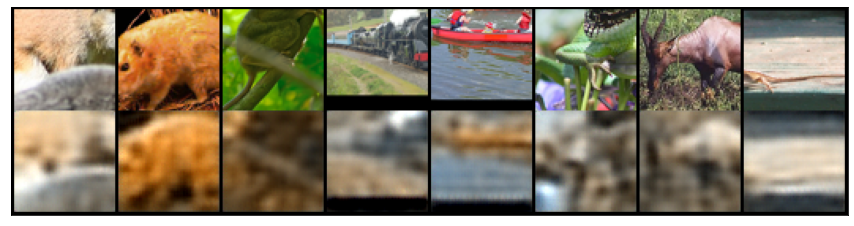

Epoch 30, loss 0.752


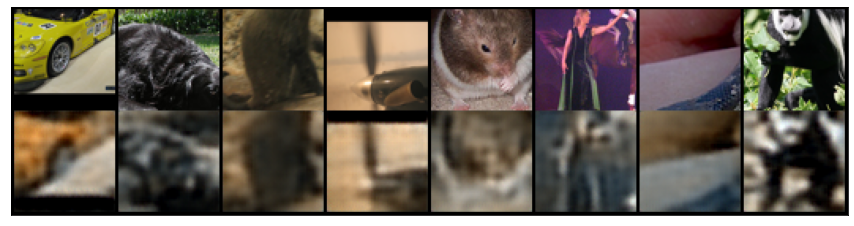

Epoch 40, loss 0.706


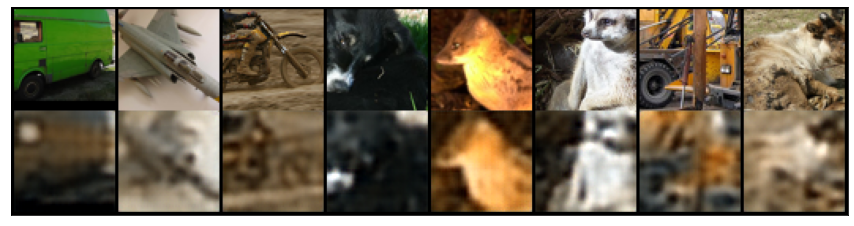

Epoch 50, loss 0.672


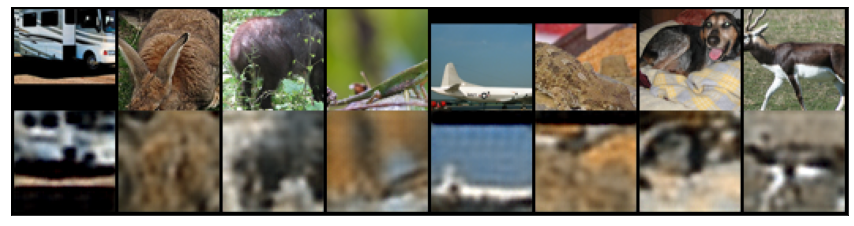

Epoch 60, loss 0.626


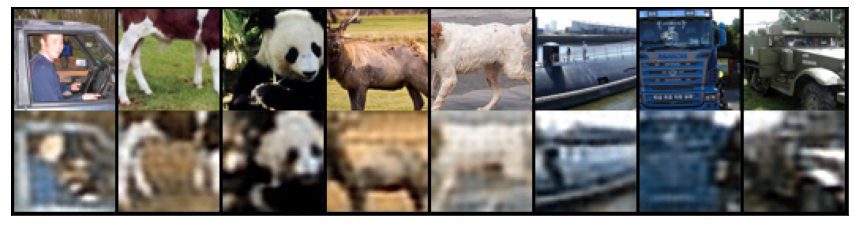

Epoch 70, loss 0.568


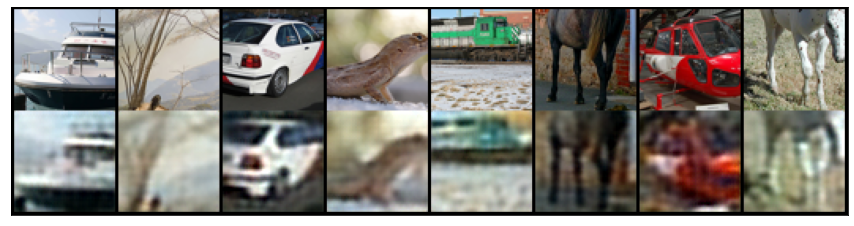

Epoch 80, loss 0.546


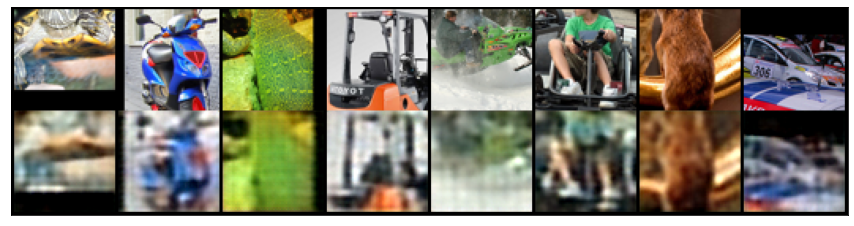

Epoch 90, loss 0.524


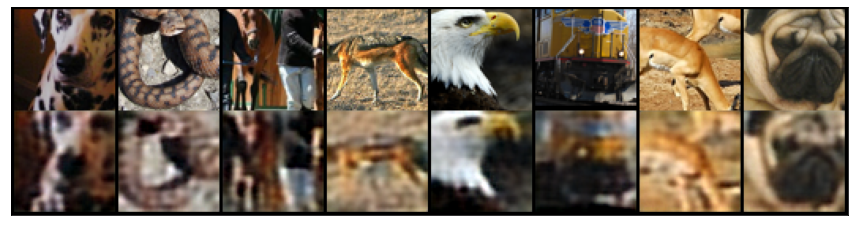

In [ ]:
# Train the autoencoder for 100 epochs
ae = Autoencoder().to(device)
ae, ae_loss_traj = train_ae(ae, dataloader_un, epochs=100)
torch.save(ae.state_dict(), 'ae.pth')

After training the autoencoder on the 100,000 images for 100 epochs, we see that autoencoder has leanred to approximately recontruct the image.

## 1.5 Train a linear classifier

Now, we ask how useful the features are for object recongition. We'll train a linear clasifier that takes the output of the encoder as its features. During training, we freeze the parameters of the encoder. To verify the effectiveness of unsupervised pretraining, we compare the linear classifier accuracy against two baselines:

* Supervised: train the encoder together with the linear classifier on the training set for 100 epochs. 
* Random weights: freeze the parameters of a randomly initialized encoder during training. 

In [ ]:
# latent representation dimension (the output dimension of the encoder)
feat_dim = 24 * 4 * 4

In [ ]:
def train_classifier(encoder, cls, dataloader, epochs=100, supervised=False):
    '''
    Args:
        encoder: trained/untrained encoder for unsupervised/supervised training.
        cls: linear classifier.
        dataloader: train partition.
        supervised: 

    Return:
        cls: linear clssifier.
    '''

    optimizer = optim.Adam(cls.parameters(), lr=0.001, weight_decay=1e-4)
    if supervised:
        optimizer = optim.Adam(list(cls.parameters())+list(encoder.parameters()), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    loss_traj = []
    accuracy_traj = []

    for epoch in tqdm_notebook(range(epochs)):

        loss_epoch = 0
        corrects_epoch = 0
        for x, y in dataloader:

            batch_size = x.size(0)
            x = x.float()
            ##############################################################################
            #                               YOUR CODE HERE                               #
            ##############################################################################
            # TODO: update the parameters of the classifer. If in supervised mode, the   #
            # parameter of the encoder is also updated.                                  #
            ##############################################################################
            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            h = encoder(x).view(batch_size,-1)
            outs = cls(h)
            loss = criterion(outs, y)
            loss.backward()
            optimizer.step()

            ##############################################################################
            #                               END OF YOUR CODE                             #
            ##############################################################################
            _, preds = torch.max(outs, 1)
            corrects_epoch += torch.sum(preds == y.data)
            loss_epoch += loss.detach()

        loss_traj.append(loss_epoch)
        epoch_acc = corrects_epoch.double() / len(dataloader.dataset)
        accuracy_traj.append(epoch_acc)
    
        if epoch % 10 == 0:
            print('Epoch {}, loss {:.3f}, train accuracy {}'.format(epoch, loss_epoch, epoch_acc))

    return cls, loss_traj

In [ ]:
def test(encoder, cls, dataloader):
    '''
    Calculate the accuracy of the trained linear classifier on the test set.
    '''
    cls.eval()

    loss_epoch = 0
    corrects_epoch = 0
    for x, y in dataloader:
        
        x = x.float()
        batch_size = x.size(0)
        x, y = x.to(device), y.to(device)
        h = encoder(x).view(batch_size, -1)
        outs = cls(h)
        _, preds = torch.max(outs, 1)
        corrects_epoch += torch.sum(preds == y.data)

    epoch_acc = corrects_epoch.double() / len(dataloader.dataset)
    print('Test accuracy {}'.format(epoch_acc))

In [ ]:
# Method I: unsupervised pretraining + training linear classifier
# Freeze the parameters of the trained autoencoder
# Train a linear classifier using the features 
linear_cls = nn.Sequential(nn.Linear(feat_dim, 10)).to(device)
cls_unsupervised, loss_traj_unsupervised = train_classifier(ae.encoder, linear_cls, dataloader_tr, epochs=100, supervised=False)
test(ae.encoder, cls_unsupervised, dataloader_te)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, loss 105.675, train accuracy 0.12760000000000002
Epoch 10, loss 79.262, train accuracy 0.29000000000000004
Epoch 20, loss 76.189, train accuracy 0.32480000000000003
Epoch 30, loss 74.038, train accuracy 0.3562
Epoch 40, loss 72.450, train accuracy 0.372
Epoch 50, loss 70.903, train accuracy 0.38380000000000003
Epoch 60, loss 69.669, train accuracy 0.399
Epoch 70, loss 69.798, train accuracy 0.3896
Epoch 80, loss 69.478, train accuracy 0.4056
Epoch 90, loss 69.247, train accuracy 0.4012
Test accuracy 0.296375


In [ ]:
# Method II: supervised training
# Train the encoder together with the linear classifier
linear_cls = nn.Sequential(nn.Linear(feat_dim, 10)).to(device)
encoder = Autoencoder().to(device).encoder
cls_supervised, loss_traj_supervised = train_classifier(encoder, linear_cls, dataloader_tr, epochs=100, supervised=True)
test(encoder, cls_supervised, dataloader_te)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, loss 88.815, train accuracy 0.1524
Epoch 10, loss 60.418, train accuracy 0.449
Epoch 20, loss 50.522, train accuracy 0.535
Epoch 30, loss 45.102, train accuracy 0.603
Epoch 40, loss 33.791, train accuracy 0.7030000000000001
Epoch 50, loss 23.845, train accuracy 0.794
Epoch 60, loss 15.177, train accuracy 0.8764000000000001
Epoch 70, loss 8.135, train accuracy 0.9372
Epoch 80, loss 1.670, train accuracy 0.9968
Epoch 90, loss 11.346, train accuracy 0.8928
Test accuracy 0.41125


In [ ]:
# Method III: random encoder + training linear classifier
# We freeze the parameters of the randomly initialized encoder during training
linear_cls = nn.Sequential(nn.Linear(feat_dim, 10)).to(device)
encoder = Autoencoder().to(device).encoder
cls_random, loss_traj_random = train_classifier(encoder, linear_cls, dataloader_tr, epochs=100, supervised=False)
test(encoder, cls_random, dataloader_te)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, loss 92.088, train accuracy 0.1022
Epoch 10, loss 91.303, train accuracy 0.20420000000000002
Epoch 20, loss 90.702, train accuracy 0.216
Epoch 30, loss 90.254, train accuracy 0.22
Epoch 40, loss 89.721, train accuracy 0.22540000000000002
Epoch 50, loss 89.525, train accuracy 0.2238
Epoch 60, loss 89.274, train accuracy 0.23320000000000002
Epoch 70, loss 89.094, train accuracy 0.2328
Epoch 80, loss 88.796, train accuracy 0.23620000000000002
Epoch 90, loss 88.572, train accuracy 0.2386
Test accuracy 0.229875


With pretrained encoder, the linear classifier should achieve about 30% accuracy on the test set. With the supervised approach, the linear classifier should achieve an accuracy above 40%. The random encoder approach performs the worse among these three. The observation that the pretrained encoder outperforms the random encoder confirms that unsupervised pretraining has learned a useful represenation. However, the quality of this learned representation is not good because it only performs slightly better than the random encoder. In the next part, we'll explore contrastive multiview coding, which learns a more useful representation than the autoencoder.

In [ ]:
del dataset_un
del dataset_te
del dataset_tr

# Part 2. Contrastive Language-Image Pre-training (CLIP)




In this part, we will implement a simplified version of the [Contrastive Language-Image Pre-training (CLIP)](https://arxiv.org/abs/2103.00020). This is a variation of the contrastive representation learning method we discussed in class. In a sentence, this model learns the relationship between a natural language sentence and the image this sentence describes. We'll learn a vector representation for images and a vector representation for natural language texts. Learning directly from raw texts gives us a broader source of supervision compared to the standard crowd-sourced labeling for image classification. It also has an advantage over most unsupervised or self-supervised learning approaches, since it doesn't just learn a representation, but also connects the representation to the natural language.

<!-- ![alt text](https://drive.google.com/uc?id=1RHmYiXeXq7vPR1MpLVE8xfqkb7jjv6Cg) -->

![alt text](https://drive.google.com/uc?id=1ZVffv0C_DcWEWnqmi_n8c1KHDWLePUWH)


The core idea behind CLIP is that, when an image matches with a natural language sentence, their vector representations should have a large dot product. Whereas, the dot product between the representations of an image and a text that are not related to each other should be small.



## Setup
As the authors suggest, in CLIP the dataset plays a major role for the performance and we need both image and texts for training the CLIP model. We will use [flickr8k](https://www.kaggle.com/datasets/adityajn105/flickr8k) to train our model. This is a small dataset with 8000 images, which would run well given the limited comuptation units on Colab. Each image in the dataset is paired with 5 captions, we will just use one of the 5 captions for simplicity. Below we displayed some sample captions corresponding to an image.


In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1csewExbHtYIcOr8BWMrGd8DqX_awmP1t' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1csewExbHtYIcOr8BWMrGd8DqX_awmP1t" -O flickr8k.zip && rm -rf /tmp/cookies.txt
!unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  id  
0  A child in a pink dress is climbing up a set o...   0  
1              A girl going into a wooden building .   0  
2   A little girl climbing into a wooden playhouse .   0  
3  A little girl climbing the stairs to her playh...   0  
4  A little girl in a pink dress going into a woo...   0

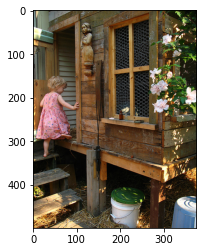

In [ ]:

# dataset pre-processing
df = pd.read_csv("captions.txt")
img_color = cv2.imread('/content/Images/'+ str(df['image'][0]),1)
plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
df.to_csv("captions.csv", index=False)
df = pd.read_csv("captions.csv")
df.head()


Here are some configuration variables, hyperparameter and utility functions that we will be using through this section:

In [ ]:
image_path = "/content/Images"
captions_path = "/content"
batch_size = 32
num_workers = 2
head_lr = 1e-3
image_encoder_lr = 1e-4
text_encoder_lr = 1e-5
weight_decay = 1e-3
patience = 1
factor = 0.8
epochs = 3

image_encoder_model = 'resnet50'
image_embedding = 2048
text_encoder_model = "distilbert-base-uncased"
text_embedding = 768
text_tokenizer = "distilbert-base-uncased"
max_length = 200

pretrained = True # for both image encoder and text encoder
trainable = True # for both image encoder and text encoder
temperature = 0.07

image_size = 64

# for projection head; used for both image and text encoders
projection_dim = 256 

class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

## Dataset

Below we are writing the custom dataloader that can handle both the images and texts necessary to train the CLIP model. It can be noted from the CLIP figure that, we need to encode both images and their describing texts. Since, we are not going to feed raw text to our text encoder! We will use the [DistilBERT](https://huggingface.co/docs/transformers/model_doc/distilbert) (which is smaller than BERT but performs nearly as well as BERT) model as our text encoder. Before that, we need to tokenize the sentences (captions) with DistilBERT tokenizer and then feed the token ids (input_ids) and the attention masks to DistilBERT. We have implemented the tokenization scheme and you do not have to implement anything for this custom dataloader.


In [ ]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)

# data augmentation for images
def get_transforms(mode="train"):
    return A.Compose(
            [
                A.Resize(image_size, image_size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

## Image Encoder
We use [ResNet50](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html) as our image encoder. It encodes each image to a fixed size vector of the model's output channels (in the case of ResNet50, it's 2048). We will load the pre-trained ImageNet weights to the ResNet50 model to get faster convergence and the limitation on the dataset size and computation resources.

In [ ]:
from torchvision.models.resnet import ResNet50_Weights
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=image_encoder_model, pretrained=pretrained, trainable=trainable
    ):
        super().__init__()
        self.model = torchvision.models.resnet50(ResNet50_Weights.IMAGENET1K_V2)
        self.model.fc = nn.Identity()

        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder
As mentioned above, we use DistilBERT as our text encoder. The output representation is a vector of size 768.

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=text_encoder_model, pretrained=pretrained, trainable=trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

## Projection Head

Now that we have encoded both our images and texts into fixed size vectors (2048 for image and 768 for text), we need to project both embeddings into a new vector space (!) with similar dimensions (256). This allows for both images and texts to be able to compare them and push apart the non-relevant image and texts and pull together those that match.

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=projection_dim,
    ):
        super().__init__()
        '''
        Args:
            embedding_dim (int): Extracted Image or text feature embedding dimenasion.
        '''

        ##############################################################################
        #                               YOUR CODE HERE                               #
        ##############################################################################
        # TODO: Initialize a single layer linear transformation for the projection   #
        # head.                                                                      #
        ##############################################################################
        self.proj = nn.Linear(embedding_dim, projection_dim)
        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################

    def forward(self, x):
        '''
        Args:
            x: Image or text feature embeddings extracted from the ResNet50 and DistilBERT model respectively.

        Return:
            projected: The projected image and text embeddings.
        '''
        ##############################################################################
        #                               YOUR CODE HERE                               #
        ##############################################################################
        # TODO: Write the forward function and normalize the out of the projection   #
        # head. hint: use F.normalize() for the normalization                        #
        ##############################################################################

        projected = self.proj(x)
        projected = F.normalize(projected)

        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################
        return projected

## CLIP
In this section, you will need to use the modules that you just implemented to build the CLIP model. The loss function we minimize is defined as:


$$
\mathcal{L}_{\text {contrast }}^{I, T}=-\frac{1}{N}\sum_{i=1}^N \log \frac{\exp(I_{i}\cdot T_{i}/\tau)}{\sum_{j=1}^{N} \exp(I_{i}\cdot T_{j}/\tau)},
$$


where $I_i$ and $T_i$ are the image feature and its corresponding text representations for the $i_{th}$ sample in a minibatch, and $N$ denotes the batch size. The constant $\tau$ is used to control the range of logits.


 
We will minimize a symmetric objective function that averages $\mathcal{L}_{\text {contrast }}^{I, T}$ and $\mathcal{L}_{\text {contrast }}^{T, I}$, i.e.,



$$\mathcal{L}=\frac{\mathcal{L}_{\text {contrast }}^{I, T}+\mathcal{L}_{\text {contrast }}^{T, I}}{2},
$$

where,
$$% \mathcal{L}_{\text {contrast }}^{I, T}=-\frac{1}{N}\sum_{i=1}^N \log \frac{\exp(I_{i}\cdot T_{i})}{\sum_{j=1}^{N} \exp(I_{i}\cdot T_{j})}\cdot\exp(\tau),
\mathcal{L}_{\text {contrast }}^{T, I}=-\frac{1}{N}\sum_{i=1}^N \log \frac{\exp(T_{i}\cdot I_{i}/\tau)}{\sum_{j=1}^{N} \exp(T_{i}\cdot I_{j}/\tau)},
$$

By minimizing the above loss function, we learn representations for the image and text such that the positive pairs (respective images and their captions) will produce high dot product while giving low dot product for negative samples (image and other unrelated captions).



In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=temperature,
        image_embedding=image_embedding,
        text_embedding=text_embedding,
    ):
        super().__init__()
        '''
        Args:
            temperature (float): temperature parameter which controls the range of the logits.
            image_embedding (int): Shape of the extracted image embedding
            text_embedding (int): Shape of the extracted text embedding

        '''

        self.image_encoder = None
        self.text_encoder = None
        self.image_projection = None
        self.text_projection = None
        self.temperature = temperature
        ##############################################################################
        #                               YOUR CODE HERE                               #
        ##############################################################################
        # TODO: Initialize the encoders and the projection heads for image and text i.e, 
        # instantiate the above None variables with their corresponding models#
        ##############################################################################
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(image_embedding)
        self.text_projection = ProjectionHead(text_embedding)
        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################
        

    def forward(self, batch):

        '''
        Args:
            batch: batch of images for training.

        Return:
            loss: computed loss.
        '''
        # get image and text features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

        loss = None
        ##############################################################################
        #                               YOUR CODE HERE                               #
        ##############################################################################
        # TODO: Project images and text into a new vector space and write the loss function by following the above equations 
        # you are not allowed to use any for loops while computing the loss.
        ##############################################################################

        proj_img = self.image_projection(image_features)
        proj_text = self.text_projection(text_features)

        dots = torch.tensordot(proj_img, proj_text, dims = ([1],[1]))/self.temperature
        dots = torch.exp(dots)

        loss_it_sum = torch.sum(dots, dim=1)
        loss_ti_sum = torch.sum(dots, dim=0)
        diagonal_dots = torch.diagonal(dots)

        loss = -0.5*(torch.log(diagonal_dots / loss_it_sum) + torch.log(diagonal_dots / loss_ti_sum))
        

        ##############################################################################
        #                               END OF YOUR CODE                             #
        ##############################################################################

        return loss.mean()


## Training
Next we will need to train the CLIP model and here are some utility functions that are necessary to train.

In [ ]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{captions_path}/captions.csv")
    dataframe = dataframe[dataframe.reset_index().index % 5 == 0]
    max_id = dataframe["id"].max() + 1
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True if mode == "train" else False,
        drop_last=True
    )
    return dataloader

def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for i, batch in enumerate(tqdm_object):
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))

        if i % 100 == 0:
            print('loss:', loss.item() / count)
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

Run this cell to train the model.

In [ ]:
train_df, valid_df = make_train_valid_dfs()
tokenizer = DistilBertTokenizer.from_pretrained(text_tokenizer)
train_loader = build_loaders(train_df, tokenizer, mode="train")
valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


model = CLIPModel().to(device)
params = [
    {"params": model.image_encoder.parameters(), "lr": image_encoder_lr},
    {"params": model.text_encoder.parameters(), "lr": text_encoder_lr},
    {"params": itertools.chain(
        model.image_projection.parameters(), model.text_projection.parameters()
    ), "lr": head_lr, "weight_decay": weight_decay}
]
optimizer = torch.optim.AdamW(params, weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=patience, factor=factor
)
step = "epoch"

best_loss = float('inf')
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}")
    model.train()
    train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
    model.eval()
    with torch.no_grad():
        valid_loss = valid_epoch(model, valid_loader)
    
    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        torch.save(model.state_dict(),  "best.pt")
        print("Saved Best Model!")
    
    lr_scheduler.step(valid_loss.avg)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:136: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and will be removed in 0.15. Please use keyword parameter(s) instead.
  f"Using {sequence_to_str(tuple(keyword_only_kwargs.keys()), separate_last='and ')} as positional "
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassifica

Epoch: 1


  0%|          | 0/202 [00:00<?, ?it/s]

loss: 0.1129487007856369
loss: 0.08186135441064835
loss: 0.06808201223611832


  0%|          | 0/50 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/202 [00:00<?, ?it/s]

loss: 0.043877534568309784
loss: 0.04353664070367813
loss: 0.048201676458120346


  0%|          | 0/50 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/202 [00:00<?, ?it/s]

loss: 0.01817253977060318
loss: 0.025207027792930603
loss: 0.032584503293037415


  0%|          | 0/50 [00:00<?, ?it/s]

## Train a Linear Classifier
We'll train a linear clasifier that takes the output of the encoder (Image Encoder: ResNet50) as its features. During training, we freeze the parameters of the encoder and only train the linear layer.

In [ ]:
labeled_transform = transforms.Compose([
    transforms.CenterCrop(64), 
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

dataset_tr = torchvision.datasets.STL10('./data', 'train', download=False, transform=labeled_transform)
dataset_te = torchvision.datasets.STL10('./data', 'test', download=False, transform=labeled_transform)
dataloader_tr = DataLoader(dataset_tr, batch_size=128, shuffle=True, num_workers=2)
dataloader_te = DataLoader(dataset_te, batch_size=128, shuffle=False, num_workers=2)
model = CLIPModel().to(device)
model.load_state_dict(torch.load("best.pt", map_location=device))
model.eval()
encoder = model.image_encoder

linear_cls = nn.Sequential(
    nn.Linear(image_embedding, 10)
    ).to(device)

cls_clip, loss_traj_clip = train_classifier(encoder, linear_cls, dataloader_tr, epochs=100, supervised=False)
test(encoder, cls_clip, dataloader_te)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0, loss 54.199, train accuracy 0.6268
Epoch 10, loss 8.111, train accuracy 0.9624
Epoch 20, loss 4.052, train accuracy 0.9902000000000001
Epoch 30, loss 2.545, train accuracy 0.9982000000000001
Epoch 40, loss 1.630, train accuracy 0.9998
Epoch 50, loss 1.191, train accuracy 1.0
Epoch 60, loss 0.939, train accuracy 1.0
Epoch 70, loss 0.736, train accuracy 1.0
Epoch 80, loss 0.601, train accuracy 1.0
Epoch 90, loss 0.523, train accuracy 1.0
Test accuracy 0.793375


With pretrained encoder, the linear classifier should achieve an accuracy > 75% on the test set. Notice that the supervised flag is set to 'False' which means we are updating the weights of the final linear layer.

# Report results

So far, we have trained linear classifiers on top of autoencoder representations and CLIP representations.

With CLIP, we learn a more useful representation than autoencoder

Please report the test accuracy of all four linear classifiers below.

### Autoencoder-based
method 1 accuracy:  30% \\
method 2 accuracy:  41% \\
method 3 accuracy:  23% \\

### CLIP
accuracy:  79%


## CLIP Inference
Now we are doing a interesting downstream task to see what CLIP has learned. We will give the model a piece of text, and let the model retrieve the most relevant images from the dataset.

First, we need to project all the images into a common search space.


In [ ]:
def get_image_embeddings(df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(text_tokenizer)
    dataloader = build_loaders(df, tokenizer, mode="valid")
    
    model = CLIPModel().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            image_features = model.image_encoder(batch["image"].to(device))
            image_embedding = model.image_projection(image_features)
            image_embeddings.append(image_embedding)
    return model, torch.cat(image_embeddings)

df, _ = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(df, "best.pt")

In this function `retrieve_images`, we will get the model, image embeddings and a text query. You need to calculate the similarities between the text and all the images and return the best `k` of them.

In [ ]:
def retrieve_images(model, image_embeddings, query, image_filenames, k=9):
    tokenizer = DistilBertTokenizer.from_pretrained(text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
  
    ##############################################################################
    #                               YOUR CODE HERE                               #
    ##############################################################################
    # TODO: Please get the top k similar images to the given text query and pass them to the 'matches' variable.
    # Note: You cannot use any for loops in this function.
    ##############################################################################
    matches = None # Please keep this as the variable name for the matches
    dots = torch.tensordot(text_embeddings, image_embeddings, dims=([1],[1]))
    _ , indices = torch.sort(dots, dim=1)
    indices = indices[0,-k:].to("cpu")
    matches = image_filenames[indices]
    ##############################################################################
    #                               END OF YOUR CODE                             #
    ##############################################################################
    
    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

Now we can query the model and get some results!

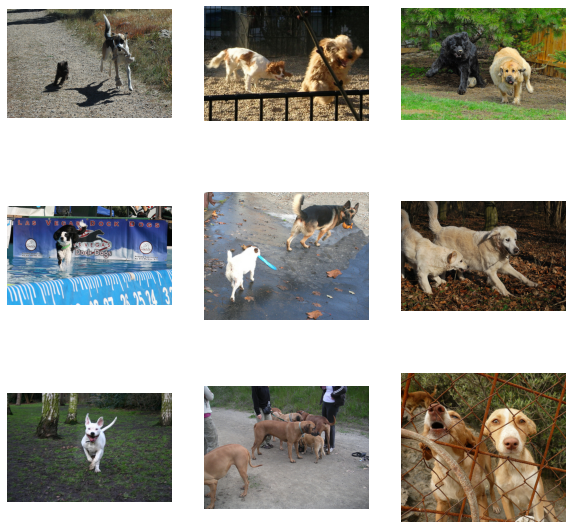

In [ ]:
retrieve_images(model, 
             image_embeddings,
             query="dogs in park",
             image_filenames=train_df['image'].values)

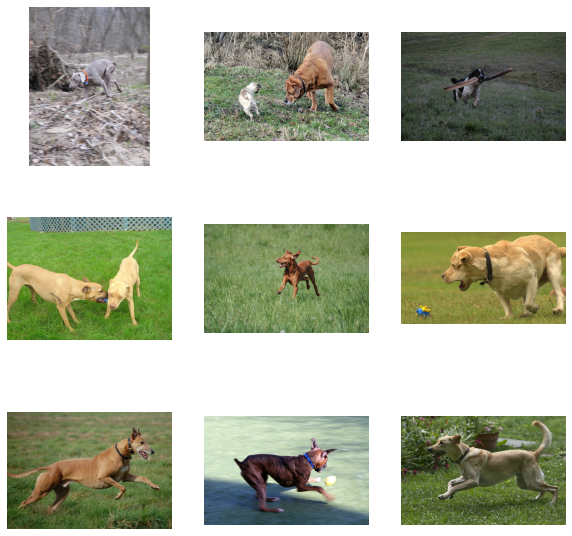

In [ ]:
retrieve_images(model, 
             image_embeddings,
             query="dogs on grass",
             image_filenames=train_df['image'].values)

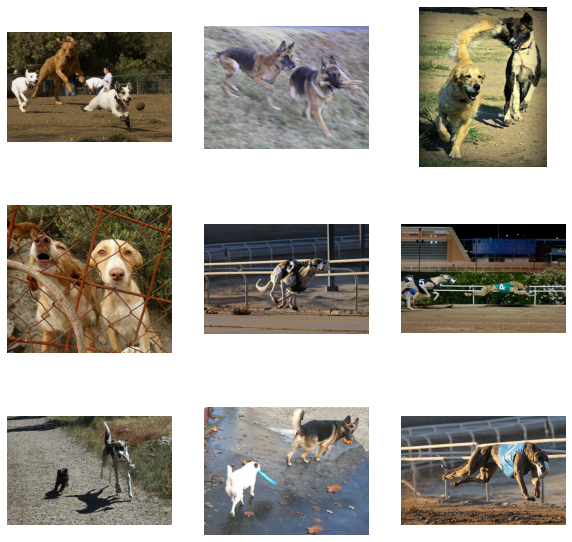

In [ ]:
retrieve_images(model, 
             image_embeddings,
             query="dogs running",
             image_filenames=train_df['image'].values)

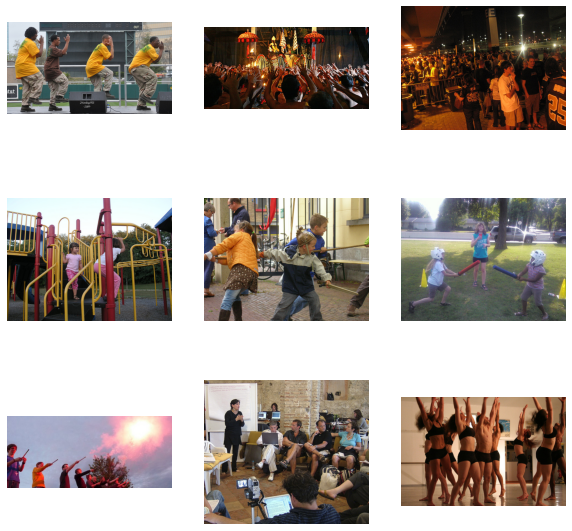

In [ ]:
retrieve_images(model, 
             image_embeddings,
             query="humans dancing and singing",
             image_filenames=train_df['image'].values)

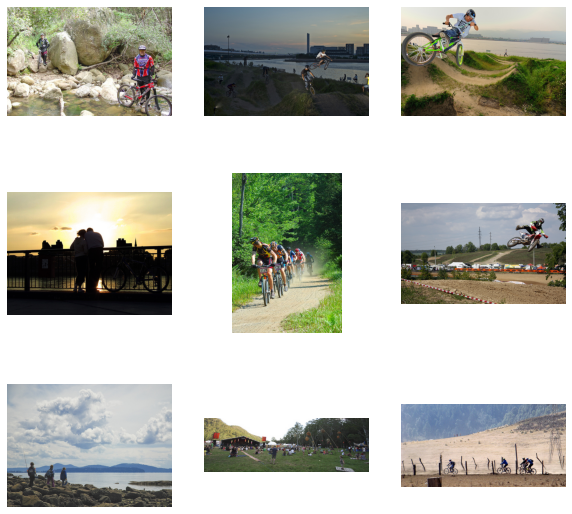

In [ ]:
retrieve_images(model, 
             image_embeddings,
             query="humans doing outdoor activities",
             image_filenames=train_df['image'].values)

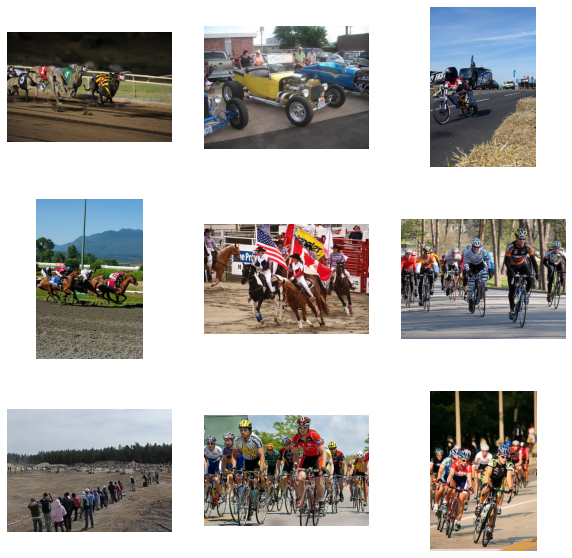

In [ ]:
retrieve_images(model, 
             image_embeddings,
             query="humans riding bikes",
             image_filenames=train_df['image'].values)

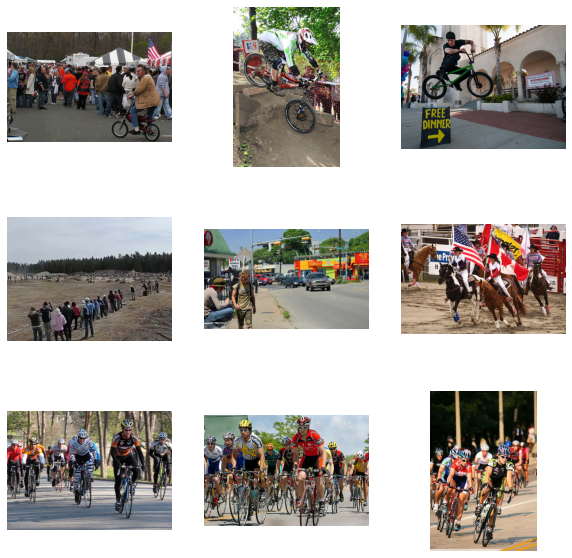

In [ ]:
retrieve_images(model, 
             image_embeddings,
             query="people riding bikes",
             image_filenames=train_df['image'].values)

# Convert to PDF

In [8]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!

# Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS_442_PS9_FA_2022_Starter_Code.ipynb'
from google.colab import files
notebookpath = '/content/drive/My Drive/Colab Notebooks/PS9_beprado.ipynb'

file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
files.download(notebookpath.split('.')[0]+'.pdf')

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state infor

FileNotFoundError: ignored